# Visualizing the pointwise entropy in a dataset

In this notebook, we will visualize the entropy of toy 2D distributions to build intuition on the parameters. In information theory, the entropy of a distribution $p(x)$ is computed as

$$
H = - \int p(x) \log p(x) dx,
$$

which, in our case, simplifies to

$$
H = \log n - \frac{1}{n} \sum_i \log \left[
    \sum_j K(X_i, X_j)
\right],
$$

where $n$ is the cardinality of the dataset, $X_i$ is the feature vector of data point $i$, and $K$ is a kernel. For a Gaussian kernel with bandwidth $\sigma$ and the L$_2$ norm as a metric of distance for $\mathcal{X} \times \mathcal{X} \rightarrow \mathbb{R}$, the equation above becomes:

$$
H = \log n - \frac{1}{n} \sum_i \log \left[
    \sum_j \exp\left(- \frac{\lVert X_i - X_j \rVert^2}{2\sigma^2}\right)
\right].
$$

When we want to compute the entropy of a new point with respect to an existing training set, this can be estimated by computing its Kernel Density Estimate given the existing points $j$,

$$
\delta H = - \log
    \sum_j K(X_{n+1}, X_j).
$$

When the point is distant from all the known points, the kernels $K(X_{n+1}, X_j)$ are small and $\delta H \rightarrow \infty$. If the point has high overlap with existing points, $\sum_j K(X_{n+1}, X_j)$ may be greater than one and lead to $\delta H < 0$.

In this example, we will use these concepts on 2D distributions to gain intuition on how this is going to look like for multi-dimensional systems.

## Preparing the notebook

Below, we create helper functions that sample a 2D Gaussian distribution with mean $(0, 0)$ and covariance matrix equal to the identity matrix. The `create_grid` function just samples the 2D space around the region where points are expected in the Gaussian.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from quests.entropy import perfect_entropy, kernel_sum, delta_entropy

In [2]:
def create_gaussian(n=100, seed=0):
    mean = np.array([0, 0])
    covariance_matrix = np.array([[1, 0], [0, 1]])
    rng = np.random.default_rng(seed)

    return rng.multivariate_normal(mean, covariance_matrix, n)

def create_grid(v=3, n=1000):
    x = np.linspace(-v, v, n)
    y = np.linspace(-v, v, n)
    xx, yy = np.meshgrid(x, y)
    grid = np.vstack([xx.ravel(), yy.ravel()]).T
    return xx, yy, grid

## Computing the estimated density

First, we visualize the KDE for the existing distribution. The bandwidth of the Gaussian kernel is $h = 0.15$ in this example.

In [3]:
samples = create_gaussian(n=100, seed=0)
xx, yy, grid = create_grid()
overlap = kernel_sum(grid, samples, h=0.15)
zz = overlap.reshape(xx.shape)

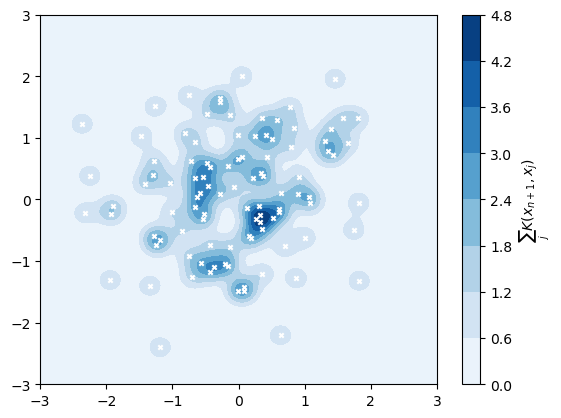

In [4]:
fig, ax = plt.subplots()

cf = ax.contourf(xx, yy, zz, cmap="Blues")
ax.scatter(samples[:, 0], samples[:, 1], marker='x', color='w', s=10)

cbar = fig.colorbar(cf)
cbar.set_label("$\sum_j K(x_{n+1}, x_j)$")
plt.show()

## Computing the point-wise entropy

The overlap should give rise to a value of entropy ($\delta H$) for each data point in the grid. We can visualize that by calling `H.delta_entropy` on the grid points:

In [5]:
dH = delta_entropy(grid, samples, h=0.15).round(8)
zz = dH.reshape(xx.shape)

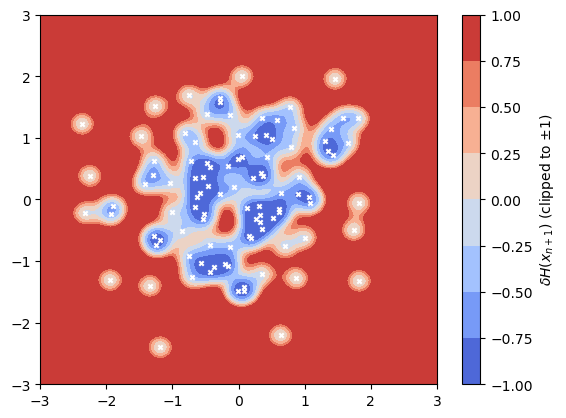

In [6]:
fig, ax = plt.subplots()

norm = plt.Normalize(vmin=-1.0, vmax=1.0)
cf = ax.contourf(xx, yy, zz.clip(-1, 1), cmap="coolwarm", norm=norm)
ax.scatter(samples[:, 0], samples[:, 1], marker='x', color='w', s=10)

cbar = fig.colorbar(cf)
cbar.set_label("$\delta H (x_{n+1})$ (clipped to $\pm 1$)")

plt.show()

The distribution above highlights with blue areas regions where the entropy is negative (i.e., points in that region do not add more information about the configuration space and basically reweight similar points), and with red areas regions where the entropy is positive. The entropy grows as we move further away from the dataset. In this case, however, we chose to clip the values of entropy to better illustrate the two regions in the same scale.

## Comparing the effects of bandwidth

One of the parameters when performing a KDE is to select a bandwidth. The parameter $h$ is important to model how much "smearing" is introduced in the distributions. For the 2D Gaussian examples, we show the entropy of points around the distribution with three values of $h$: 0.10, 0.25, and 0.50.

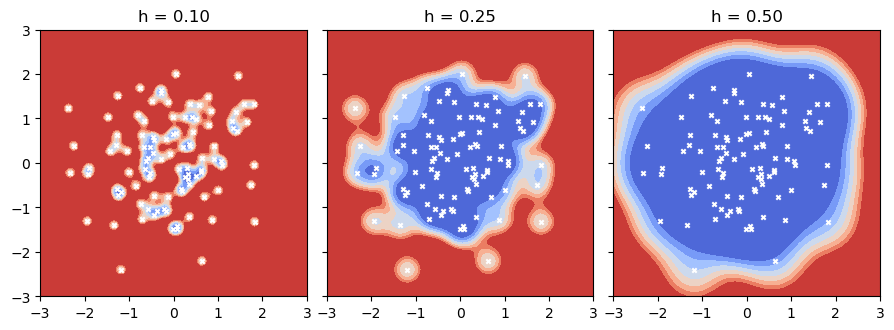

In [7]:
fig, ax_fig = plt.subplots(1, 3, figsize=(9, 4), sharey=True, sharex=True)

norm = plt.Normalize(vmin=-1, vmax=1)
samples = create_gaussian()

for ax, h in zip(ax_fig, [0.1, 0.25, 0.5]):
    dH = delta_entropy(grid, samples, h=h)
    zz = dH.reshape(xx.shape).clip(-1, 1)
    cf = ax.contourf(xx, yy, zz, cmap="coolwarm", norm=norm)
    ax.scatter(samples[:, 0], samples[:, 1], marker='x', color='w', s=10)
    ax.set_title(f"h = {h:0.2f}")
    ax.set_aspect("equal")

fig.tight_layout()
plt.show()

In the distributions above, the larger bandwidth broadens the space around the points. This implies that lower values of entropy are expected closer to the training set.

## Rescaling datasets

To verify how coverage of the input space can influence the entropy, we take the same distribution and rescale the positions by a given factor $f$. Then, we compute the dataset entropy $H$ and visualize how the pointwise entropies look like for each distribution. Because datasets with points spread out have broader distributions, their entropy is expected to be larger.

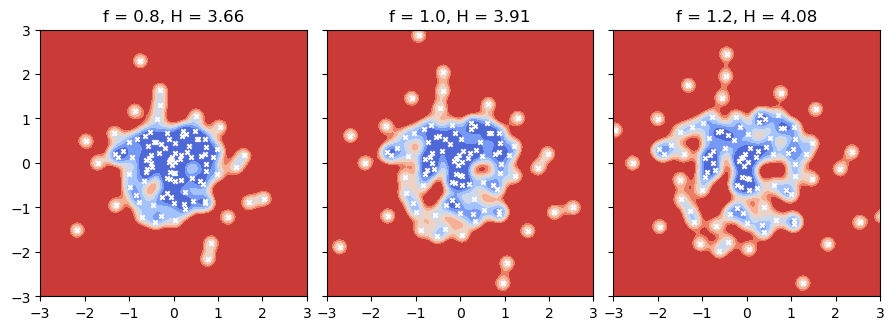

In [8]:
fig, ax_fig = plt.subplots(1, 3, figsize=(9, 4), sharey=True, sharex=True)

samples = create_gaussian(n=100, seed=1)

norm = plt.Normalize(vmin=-1.0, vmax=1.0)

for ax, factor in zip(ax_fig, [0.8, 1.0, 1.2]):
    pts = factor * samples
    
    dH = delta_entropy(grid, pts, h=0.15).round(8)
    H = perfect_entropy(pts, h=0.15)
    zz = dH.reshape(xx.shape).clip(-1, 1)
    cf = ax.contourf(xx, yy, zz, cmap="coolwarm", norm=norm)
    ax.scatter(pts[:, 0], pts[:, 1], marker='x', color='w', s=10)
    ax.set_title(f"f = {factor:0.1f}, H = {H:0.2f}")
    ax.set_aspect("equal")
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

fig.tight_layout()
plt.show()

As shown in the distributions above (and calculated values of entropy), the distribution with positions rescaled to 120% of their original size have higher entropy. On the other hand, the more concentrated distribution has lower entropy, as the points are sampling redundant portions of the input space.